# Title: Multivariate Time Series Analysis and Stock Price Prediction

'''
Description:
This notebook explores multivariate time series analysis and stock price prediction using recurrent neural networks (RNNs) such as LSTM, SimpleRNN, and GRU. The analysis focuses on four major stock indices: NIFTY, FINANCE, IT, and PHARMA. It covers data preprocessing, exploratory data analysis (EDA), model building, and evaluation.

The notebook includes the following key steps:
1. Data Preparation: Importing necessary libraries and loading historical stock price data for the four indices.
2. Data Preprocessing: Handling missing values, detecting outliers, and exploring the data through EDA.
3. Model Building: Building and training RNN models for univariate, continuous, and discrete data.
4. Model Evaluation: Evaluating model performance using metrics such as mean squared error (MSE), root mean squared error (RMSE), and R-squared.

The goal of this analysis is to compare the performance of different RNN architectures and determine the most effective model for stock price prediction.
'''

In [1]:
import sys
import os
import numpy as np
import tensorflow as tf
import random
import keras
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import LSTM, SimpleRNN, GRU, Dropout, Dense
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
from tabulate import tabulate

# Printing Python version
print(sys.version)


3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


### Pre Defined Functions

'''

1. `reset_random_seeds()`: Resets random seeds for reproducibility.
2. `performance_measure(model, test, timesteps)`: Evaluates the performance of a model on test data.
3. `plot_data(Y_test, Y_pred, model_name)`: Plots actual vs predicted data.
4. `train_model(train, timesteps, batch, epochs, model_type)`: Trains a recurrent neural network model.
5. `ema_signal(df, window=8)`: Calculates exponential moving average (EMA) and generates a signal based on whether the price is above or below EMA.
6. `stochastic_signal(df, period=8)`: Calculates Stochastic Oscillator and discrete signals based on %K values.
7. `larry_williams_signal(df, period=8)`: Calculates Larry Williams %R and discrete signals based on %R values.
8. `ma_signal(df, window=5)`: Calculates simple moving average (SMA) and generates a signal based on whether the price is above or below SMA.
9. `inverse_transform(true, predicted, num_features, scaler)`: Inverse transforms scaled true and predicted values back to their original scale.
10. `aggregate_metric(mse_values, rmse_values, r_squared_values, weights=None)`: Aggregates multiple evaluation metrics into a single value.
11. `evaluate_and_plot(LSTM_model, SimpleRNN_model, GRU_model, test, timesteps, num_features, sc)`: Evaluates multiple recurrent neural network models and plots their predictions against the actual values.
12. `split_data(series, train_percentage=0.7)`: Splits the input series into train and test data.
13. `normalize_data(train_data, test_data)`: Normalizes training and test data using MinMaxScaler.
14. `preprocess_dataframe(df, title="DataFrame")`: Preprocesses a DataFrame by handling missing values with forward fill.
15. `detect_outliers(df, threshold=3)`: Detects outliers in a DataFrame.
16. `visualize_results(df_univariate, df_continuous, df_discrete)`: Visualizes the results of continuous and discrete data.

'''

In [2]:
# Setting the random seeds for reproducibility
def reset_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(1)
    tf.random.set_seed(1)
    np.random.seed(1)
    random.seed(1)

In [3]:
def preprocess_dataframe(df, title="DataFrame"):
    """
    Preprocesses a DataFrame by handling missing values with forward fill.

    Parameters:
    - df (DataFrame): Input DataFrame.
    - title (str): Title to be printed before any information.

    Returns:
    - df (DataFrame): Preprocessed DataFrame with missing values filled using forward fill.
    """
    # Print the title
    

    # Check if there are any missing values
    if df.isnull().values.any():
        print("\n" + title)
        # Print the number of missing values in each column
        print("\nNumber of missing values in each column:")
        print(df.isnull().sum())

        # Use boolean indexing to filter rows with missing values
        rows_with_missing_values = df[df.isnull().any(axis=1)]

        # Print the rows with missing values
        print("\nRows with missing values:")
        print(rows_with_missing_values)

        # Fill missing values with forward fill
        df.fillna(method='ffill', inplace=True)

        # Print the number of missing values after filling
        print("\nNumber of missing values after forward fill:")
        print(df.isnull().sum())
    else:
        print("\n" + title)
        print("No missing values found.")

    return df

In [4]:
def detect_outliers(df, threshold=3):
    """
    Detect outliers in a DataFrame.

    Parameters:
    - df: DataFrame containing the data
    - threshold: Threshold for identifying outliers based on z-score

    Returns:
    - DataFrame containing rows with outliers
    """
    # Define the numerical columns to detect outliers for
    numerical_columns = ['Open', 'High', 'Low', 'Close']

    # Calculate z-scores for each data point in the numerical columns
    z_scores = (df[numerical_columns] - df[numerical_columns].mean()) / df[numerical_columns].std()

    # Create a boolean mask where True indicates the presence of an outlier
    outliers_mask = (z_scores > threshold) | (z_scores < -threshold)

    # Filter the DataFrame to show only rows with outliers
    outliers_df = df[outliers_mask.any(axis=1)]

    return outliers_df

In [5]:
def ema_signal(df, window=14):
    """
    Calculate exponential moving average (EMA) and generate a signal based on whether the price is above or below EMA.

    Parameters:
    - df (DataFrame): Input DataFrame containing the 'Close' prices.
    - window (int): Window size for EMA calculation. Default is 14.

    Returns:
    - df (DataFrame): Input DataFrame with additional columns for EMA and EMA signal.
    """

    # Calculate exponential moving average
    ema = df['Close'].ewm(span=window, min_periods=window, adjust=False).mean()

    # Append EMA values to the DataFrame
    df['EMA'] = ema

    # Add a column indicating whether the price is above or below EMA
    df['EMA_discrete'] = np.where(df['Close'] > ema, 1, -1)

    return df




def stochastic_signal(df, period=14):
    """
    Calculate Stochastic Oscillator and discrete signals based on %K values.
    
    Parameters:
    df (DataFrame): Input DataFrame containing 'Low', 'High', and 'Close' columns.
    period (int): Period for calculating the rolling window (default is 14).

    Returns:
    DataFrame: DataFrame with Stochastic Oscillator values and discrete signals added.
    """

    # Calculate lowest low and highest high over the specified period
    df['Lowest_Low'] = df['Low'].rolling(window=period).min()
    df['Highest_High'] = df['High'].rolling(window=period).max()

    # Calculate %K (Stochastic Oscillator)
    df['%K'] = ((df['Close'] - df['Lowest_Low']) / (df['Highest_High'] - df['Lowest_Low'])) * 100

    # Set Stochastic Oscillator equal to %K
    df['Stochastic'] = df['%K']
    
    # Shift %K by 1 time step to compare with previous value
    df['%K_previous'] = df['%K'].shift(1)

    # Determine trend opinion based on the change in %K value
    df['Stochastic_discrete'] = 0
    df.loc[df['%K'] > df['%K_previous'], 'Stochastic_discrete'] = 1  # If %K increases, trend is up
    df.loc[df['%K'] < df['%K_previous'], 'Stochastic_discrete'] = -1  # If %K decreases, trend is down

    # Drop temporary columns used for calculations
    df.drop(['Lowest_Low', 'Highest_High', '%K_previous'], axis=1, inplace=True)

    return df


def larry_williams_signal(df, period=14):
    """
    Calculate Larry Williams %R and discrete signals based on %R values.

    Parameters:
    df (DataFrame): Input DataFrame containing 'Low', 'High', and 'Close' columns.
    period (int): Period for calculating the rolling window (default is 14).

    Returns:
    DataFrame: DataFrame with Larry Williams %R values and discrete signals added.
    """

    # Calculate lowest low and highest high over the specified period
    df['Lowest_Low'] = df['Low'].rolling(window=period).min()
    df['Highest_High'] = df['High'].rolling(window=period).max()

    # Calculate %R (Larry Williams %R)
    df['%R'] = ((df['Highest_High'] - df['Close']) / (df['Highest_High'] - df['Lowest_Low'])) * -100
    
    df['Williams'] = df['%R']
    
    # Shift %R by 1 time step to compare with previous value
    df['%R_previous'] = df['%R'].shift(1)

    # Determine trend opinion based on the change in %R value
    df['Williams_discrete'] = 0
    df.loc[df['%R'] > df['%R_previous'], 'Williams_discrete'] = 1  # If %R increases, trend is up
    df.loc[df['%R'] < df['%R_previous'], 'Williams_discrete'] = -1  # If %R decreases, trend is down

    # Drop temporary columns used for calculations
    df.drop(['Lowest_Low', 'Highest_High', '%R_previous'], axis=1, inplace=True)

    return df




def ma_signal(df, window=14):
    """
    Calculate simple moving average (SMA) and generate a signal based on whether the price is above or below SMA.

    Parameters:
    - df (DataFrame): Input DataFrame containing the 'Close' prices.
    - window (int): Window size for SMA calculation. Default is 14.

    Returns:
    - df (DataFrame): Input DataFrame with additional columns for SMA and SMA signal.
    """

    # Calculate simple moving average
    sma = df['Close'].rolling(window=window, min_periods=1).mean()

    # Append SMA values to the DataFrame
    df['SMA'] = sma

    # Add a column indicating whether the price is above or below SMA
    df['SMA_discrete'] = np.where(df['Close'] > sma, 1, -1)

    return df

In [6]:
def split_data(series, train_percentage=0.7):
    """
    Split the input series into train and test data.

    Args:
    - series: Input series to be split
    - train_percentage: Percentage of data to be used for training (default is 0.7)

    Returns:
    - train_data: Training data
    - test_data: Test data
    """

    # Calculate lengths for each split
    total_length = len(series)  # Total length of the input series
    train_length = int(train_percentage * total_length)  # Length of the training data

    # Train data: Select the portion of data for training
    train_data = series[:train_length]

    # Test data: Select the portion of data for testing
    test_data = series[train_length:]

    # Print shapes of train and test data (optional, for debugging)
    print(train_data.shape, test_data.shape)

    return train_data, test_data

In [7]:
def normalize_data(train_data, test_data):
    """
    Function to normalize training and test data using MinMaxScaler.

    Parameters:
    train_data (numpy array): Training data to be normalized.
    test_data (numpy array): Test data to be normalized.

    Returns:
    tuple: Tuple containing normalized training data, normalized test data, and scaler object.
    """
    # Initialize MinMaxScaler
    sc = MinMaxScaler()

    # Fit and transform training data
    train_normalized = sc.fit_transform(train_data)

    # Transform test data
    test_normalized = sc.transform(test_data)

    # Print shapes of normalized data for verification
    print(train_normalized.shape, test_normalized.shape)

    # Return normalized data and scaler object
    return train_normalized, test_normalized, sc

In [8]:
def train_model(train, timesteps, batch, epochs, model_type):
    X_train = []
    Y_train = []
  
    # Loop for training data
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    
    reset_random_seeds()
    
    # Determine the RNN type based on the input model_type
    if model_type == 'LSTM':
        rnn_layer = LSTM
    elif model_type == 'SimpleRNN':
        rnn_layer = SimpleRNN
    elif model_type == 'GRU':
        rnn_layer = GRU
    else:
        raise ValueError("Invalid model type. Please choose 'LSTM', 'SimpleRNN', or 'GRU'.")
    
    # Adding Layers to the model
    model = Sequential()
    model.add(rnn_layer(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True,
                        activation='relu'))
    model.add(rnn_layer(32, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=optimizers.Adam(), loss='mean_squared_error')
    print(model.summary())
  
    # Training the data
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch, verbose=0, shuffle=False)
    model.reset_states()
    return model

In [9]:
def evaluate_and_plot(LSTM_model, SimpleRNN_model, GRU_model, test, timesteps, num_features, sc):
    # List of models and their corresponding names
    models = [LSTM_model, SimpleRNN_model, GRU_model]
    model_names = ['LSTM', 'SimpleRNN', 'GRU']
    results = []

    # Evaluate each model
    for model, model_name in zip(models, model_names):
        # Evaluate performance metrics
        mse, rmse, r_squared, true, predicted = performance_measure(model, test, timesteps)
        # Aggregate metrics into a single value
        aggregate_metrics = aggregate_metric(mse, rmse, r_squared)
        # Append results to the list
        results.append([model_name, mse, rmse, r_squared, aggregate_metrics])

    # Headers for the table
    headers = ["Model", "MSE", "RMSE", "R-Squared", "Aggregate Metrics"]

    # Create DataFrame from results
    df = pd.DataFrame(results, columns=headers)

    # Find the best model based on aggregate metrics
    best_model = df[df['Aggregate Metrics'] == df['Aggregate Metrics'].max()]

    # Print the table with the best model highlighted
    print(best_model.to_string(index=False))

    # Extract the name of the best model
    best_model_name = best_model['Model'].values[0]

    # Plot data for the best model
    if best_model_name == "LSTM":
        true, predicted = inverse_transform(true, predicted, num_features, sc)
        plot_data(true, predicted, 'LSTM')
    elif best_model_name == "SimpleRNN":
        true, predicted = inverse_transform(true, predicted, num_features, sc)
        plot_data(true, predicted, 'RNN')
    elif best_model_name == "GRU":
        true, predicted = inverse_transform(true, predicted, num_features, sc)
        plot_data(true, predicted, 'GRU')

    return df

In [10]:
# Function to plot the actual vs predicted data
def plot_data(Y_test, Y_pred, model_name):
    # Plot actual data in blue
    plt.plot(Y_test, c='r')
    
    # Plot predicted data in green
    plt.plot(Y_pred, c='g')
    
    # Label x-axis
    plt.xlabel('Day')
    
    # Label y-axis
    plt.ylabel('Price')
    
    # Title of the plot
    plt.title(f'Stock Prediction Graph using {model_name} model')
    
    # Adding legend for better understanding
    plt.legend(['Actual', 'Predicted'], loc='lower right')
    
    # Display the plot
    plt.show()

In [11]:
def inverse_transform(true, predicted, num_features, scaler):
    """
    Inverse transform scaled true and predicted values back to their original scale using the provided scaler.

    Args:
    true (numpy.ndarray): Array of true target values.
    predicted (numpy.ndarray): Array of predicted target values.
    num_features (int): Number of features in the dataset.
    scaler: Scaler object used for scaling the data.

    Returns:
    numpy.ndarray: Inverse transformed true values.
    numpy.ndarray: Inverse transformed predicted values.
    """

    # Reshape true and predicted arrays to be 2-dimensional
    true = true.reshape(-1, 1)
    predicted = predicted.reshape(-1, 1)

    # Repeat true and predicted arrays along the columns to match the original number of features
    true = np.repeat(true, num_features, axis=1)
    predicted = np.repeat(predicted, num_features, axis=1)
    
    # Apply inverse_transform using the provided scaler
    true = scaler.inverse_transform(true)
    predicted = scaler.inverse_transform(predicted)

    # Discard repeated values to obtain 1-dimensional arrays
    true = true[:, 0]
    predicted = predicted[:, 0]

    return true, predicted

In [12]:
def aggregate_metric(mse_values, rmse_values, r_squared_values, weights=None):
    def scale_to_100(value):
        """Scale the value to a maximum of 100."""
        max_value = max(value)
        if max_value > 100:
            scale_factor = 100 / max_value
            scaled_values = [v * scale_factor for v in value]
            return scaled_values
        return value
    
    # Set default weights if not provided
    weights = [1, 1, 1] if weights is None else weights
    
    # Normalize weights to ensure they sum up to 1
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]
    
    # Check if input values are single floats, convert them to lists
    if isinstance(mse_values, (float, np.float64)):
        mse_values = [mse_values]
    if isinstance(rmse_values, (float, np.float64)):
        rmse_values = [rmse_values]
    if isinstance(r_squared_values, (float, np.float64)):
        r_squared_values = [r_squared_values]
    
    # Invert MSE and RMSE values
    inverted_mse_values = [1 / mse for mse in mse_values]
    inverted_rmse_values = [1 / rmse for rmse in rmse_values]
    
    # Scale inverted MSE and RMSE values to 100 if necessary
    inverted_mse_values = scale_to_100(inverted_mse_values)
    inverted_rmse_values = scale_to_100(inverted_rmse_values)
    
    # Calculate aggregate metric by combining individual metrics with weights
    aggregate_metric_value = 0.0
    for mse, rmse, r_squared in zip(inverted_mse_values, inverted_rmse_values, r_squared_values):
        aggregate_metric_value += (weights[0] * mse) + (weights[1] * rmse) + (weights[2] * r_squared)
    
    return aggregate_metric_value

In [13]:
def performance_measure(model, test, timesteps):
    """
    Evaluate the performance of a model on test data.

    Parameters:
    - model: The trained model to be evaluated.
    - test: The test data.
    - timesteps: Number of timesteps for each input sequence.

    Returns:
    - mse: Mean squared error between true and predicted values.
    - rmse: Root mean squared error between true and predicted values.
    - r: R-squared score between true and predicted values.
    - Y_test: True target values from the test data.
    - Y_pred: Predicted target values by the model.
    """
    X_test = []
    Y_test = []

    # Loop for creating input sequences and target values
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i - timesteps:i])
        Y_test.append(test[i][0])
        
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Prediction
    Y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = sqrt(mse)
    r_squared = r2_score(Y_test, Y_pred)
    
    return mse, rmse, r_squared, Y_test, Y_pred

In [14]:
def visualize_results(df_univariate, df_continuous, df_discrete):
    # Define headers for the table
    headers = ['Model', 'MSE', 'RMSE', 'R-Squared', 'Aggregate Metrics']
    
    # Print results for univariate data
    print("\nResults for Univariate Data:")
    print(tabulate(df_univariate, headers=headers, tablefmt='pretty', showindex=False))
    
    # Print results for continuous data
    print("Results for Continuous Data:")
    # Use tabulate to print DataFrame in a formatted table
    print(tabulate(df_continuous, headers=headers, tablefmt='pretty', showindex=False))
    
    # Print results for discrete data
    print("\nResults for Discrete Data:")
    # Use tabulate to print DataFrame in a formatted table
    print(tabulate(df_discrete, headers=headers, tablefmt='pretty', showindex=False))

### Data Preprocessing

In [15]:
# Call the function to reset random seeds
reset_random_seeds()

In [16]:
# Read the CSV files for each stock index, specifying parsing of dates and setting the first column as the index
NIFTY50 = pd.read_csv("NIFTY50.csv",parse_dates = True,index_col=0)
CNXFIN = pd.read_csv("CNXFIN.csv",parse_dates = True,index_col=0)
CNXIT = pd.read_csv("CNXIT.csv", parse_dates=True, index_col=0)
CNXPHARMA = pd.read_csv("CNXPHARMA.csv", parse_dates=True, index_col=0)

#### Handling Missing Values

In [17]:
# Preprocess the DataFrames by handling missing values
NIFTY = preprocess_dataframe(NIFTY50.copy(),'NIFTY')
FINANCE = preprocess_dataframe(CNXFIN.copy(),'FINANCE')
IT = preprocess_dataframe(CNXIT.copy(),'IT')
PHARMA = preprocess_dataframe(CNXPHARMA.copy(),'PHARMA')


NIFTY

Number of missing values in each column:
Open     13
High     13
Low      13
Close    13
dtype: int64

Rows with missing values:
            Open  High  Low  Close
Date                              
17-02-2014   NaN   NaN  NaN    NaN
22-03-2014   NaN   NaN  NaN    NaN
24-04-2014   NaN   NaN  NaN    NaN
15-10-2014   NaN   NaN  NaN    NaN
01-01-2015   NaN   NaN  NaN    NaN
28-02-2015   NaN   NaN  NaN    NaN
15-04-2015   NaN   NaN  NaN    NaN
01-01-2016   NaN   NaN  NaN    NaN
12-08-2016   NaN   NaN  NaN    NaN
01-01-2018   NaN   NaN  NaN    NaN
01-01-2019   NaN   NaN  NaN    NaN
27-10-2019   NaN   NaN  NaN    NaN
14-11-2020   NaN   NaN  NaN    NaN

Number of missing values after forward fill:
Open     0
High     0
Low      0
Close    0
dtype: int64

FINANCE

Number of missing values in each column:
Open     17
High     17
Low      17
Close    17
dtype: int64

Rows with missing values:
            Open  High  Low  Close
Date                              
22-03-2014   NaN   NaN  Na

#### Outlier Detection

In [18]:
# List of DataFrame names
df_names = ['NIFTY', 'FINANCE', 'IT', 'PHARMA']

# Loop through each DataFrame
for df_name in df_names:
    # Get the DataFrame
    df = globals()[df_name]
    
    # Detect outliers
    outliers = detect_outliers(df)
    
    # Print the outliers
    print(f"Outliers in {df_name}:")
    print(outliers)
    print("\n")

Outliers in NIFTY:
Empty DataFrame
Columns: [Open, High, Low, Close]
Index: []


Outliers in FINANCE:
Empty DataFrame
Columns: [Open, High, Low, Close]
Index: []


Outliers in IT:
Empty DataFrame
Columns: [Close, Open, High, Low]
Index: []


Outliers in PHARMA:
Empty DataFrame
Columns: [Close, Open, High, Low]
Index: []




### Exploratory Data Analysis

In [19]:
# Correlation matrix
NIFTY.corr()['Close']

Open     0.999698
High     0.999856
Low      0.999858
Close    1.000000
Name: Close, dtype: float64

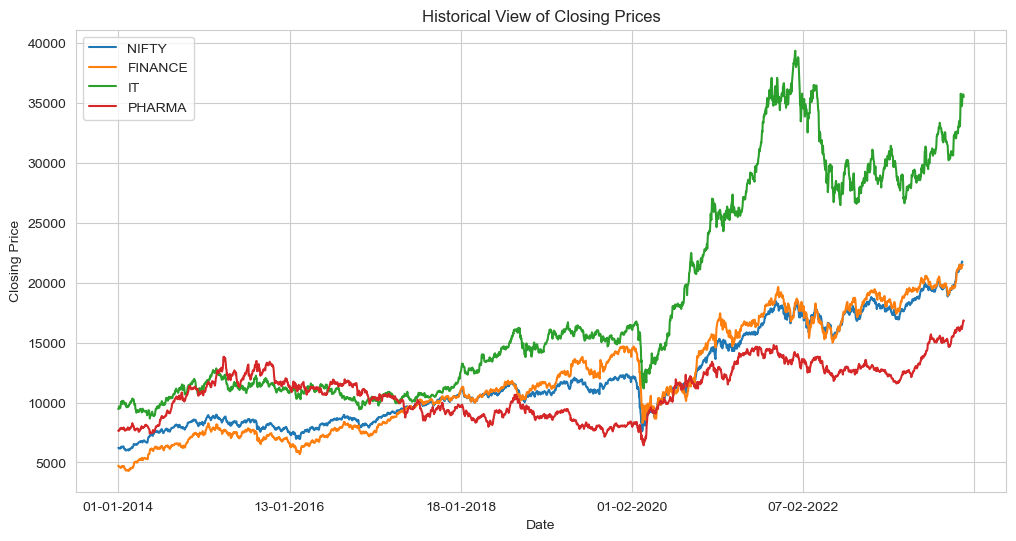

In [20]:
# Plotting closing prices for NIFTY, FINANCE, IT, and PHARMA
plt.figure(figsize=(12, 6))
NIFTY['Close'].plot(label='NIFTY', legend=True)
FINANCE['Close'].plot(label='FINANCE', legend=True)
IT['Close'].plot(label='IT', legend=True)
PHARMA['Close'].plot(label='PHARMA', legend=True)

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Historical View of Closing Prices')

# Show plot
plt.show()

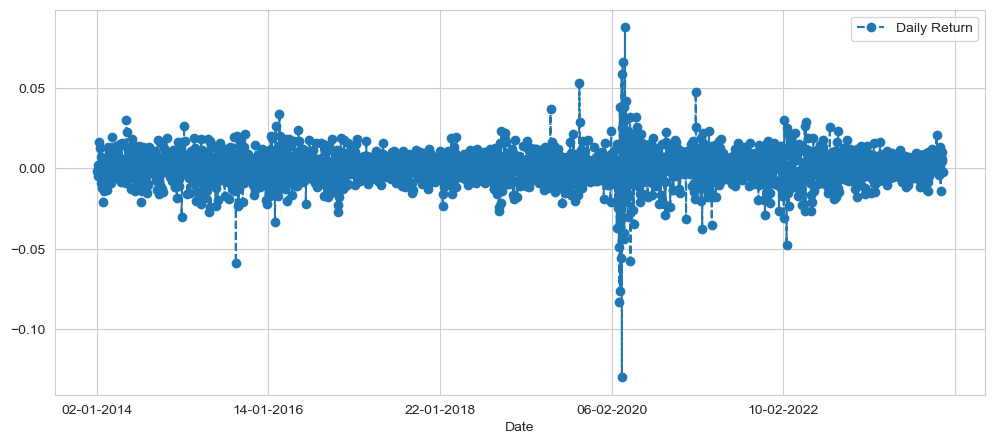

In [21]:
# Use pct_change to calculate the percent change for each day in the 'Close' column of the NIFTY DataFrame
NIFTY['Daily Return'] = NIFTY['Close'].pct_change()

# Plot the daily return percentage using matplotlib
NIFTY['Daily Return'].plot(figsize=(12, 5), legend=True, linestyle='--', marker='o')

# Show the plot
plt.show()

C:\Users\gjisl\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


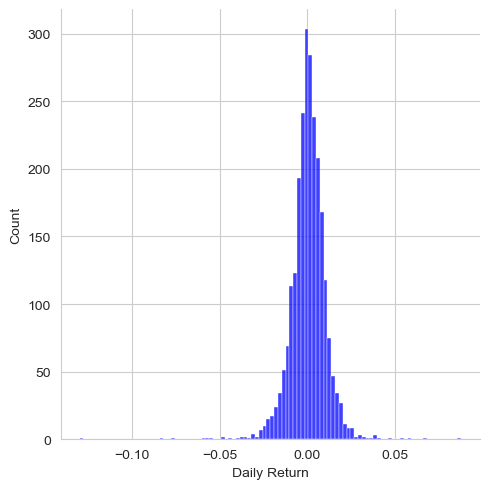

In [22]:
# Plotting a distribution of daily returns from NIFTY data
sns.displot(NIFTY['Daily Return'].dropna(), bins=100, color='blue')
plt.show()

In [23]:
# Create a DataFrame for NIFTY closing prices and rename the column
NIFTY_close = pd.DataFrame(NIFTY['Close'])
NIFTY_close = NIFTY_close.rename(columns={"Close": "NIFTY_close"})

# Create a DataFrame for FINANCE closing prices and rename the column
FINANCE_close = pd.DataFrame(FINANCE['Close'])
FINANCE_close = FINANCE_close.rename(columns={"Close": "FINANCE_close"})

# Create a DataFrame for IT closing prices and rename the column
IT_close = pd.DataFrame(IT['Close'])
IT_close = IT_close.rename(columns={"Close": "IT_close"})

# Create a DataFrame for PHARMA closing prices and rename the column
PHARMA_close = pd.DataFrame(PHARMA['Close'])
PHARMA_close = PHARMA_close.rename(columns={"Close": "PHARMA_close"})

# Concatenate all closing price DataFrames horizontally (axis=1)
closing_df = pd.concat([NIFTY_close, FINANCE_close, IT_close, PHARMA_close], axis=1)

# Display the first few rows of the concatenated DataFrame
closing_df.head()

,NIFTY_close,FINANCE_close,IT_close,PHARMA_close
Date,,,,
02-01-2014,6221.149902,4665.000000,9478.35,7625.10
03-01-2014,6211.149902,4664.100098,9673.20,7663.10
06-01-2014,6191.450195,4628.350098,9640.75,7697.25
07-01-2014,6162.250000,4619.250000,9522.75,7714.15
08-01-2014,6174.600098,4626.350098,9531.55,7806.60


In [24]:
# Calculate the percentage change of each value in the DataFrame 'closing_df'
returns = closing_df.pct_change()

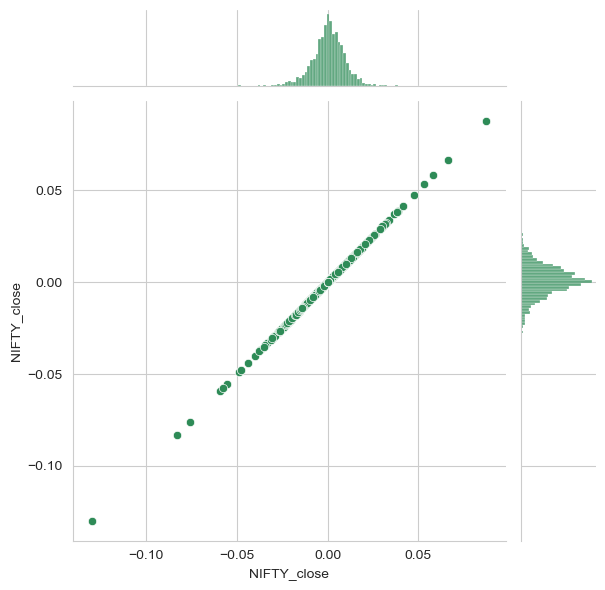

In [25]:
# Comparing Nifty to itself
sns.jointplot(x='NIFTY_close', y='NIFTY_close', data=returns, kind='scatter', color='seagreen')
plt.show()

C:\Users\gjisl\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


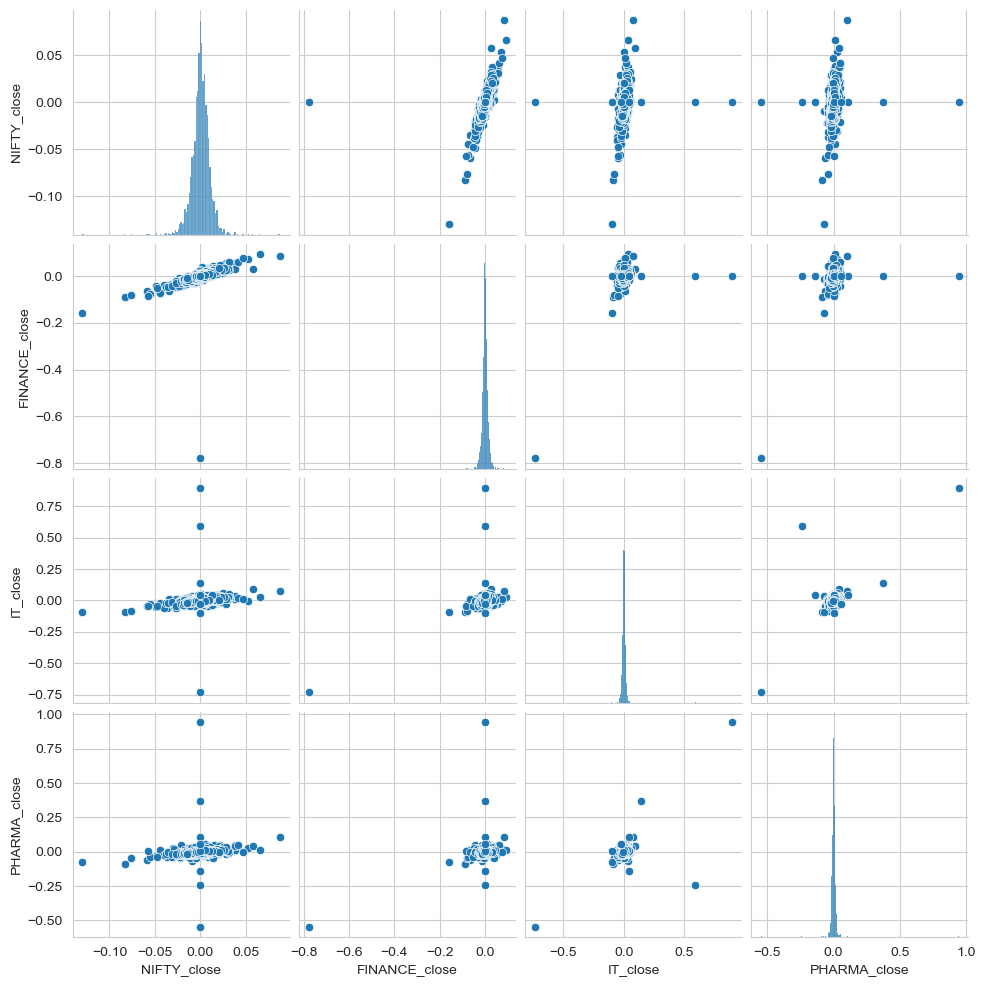

In [26]:
# Creating a pairplot using Seaborn to visualize pairwise relationships
sns.pairplot(returns.dropna())
plt.show()

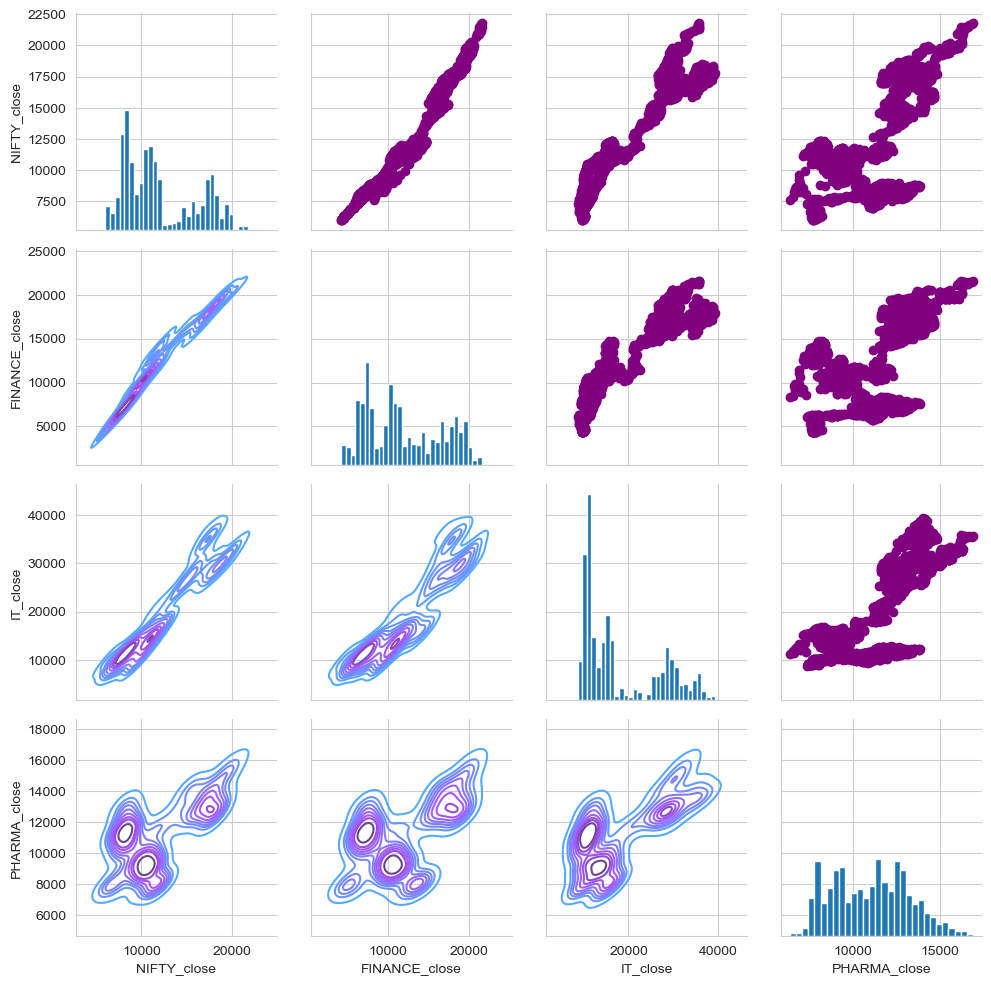

In [27]:
# Set up a PairGrid plot named returns_fig on the DataFrame closing_df
returns_fig = sns.PairGrid(closing_df)

# Customize the upper triangle of the PairGrid plot with scatter plots colored in purple
returns_fig.map_upper(plt.scatter, color='purple')

# Customize the lower triangle of the PairGrid plot with kernel density estimation plots using the 'cool_d' colormap
returns_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Customize the diagonal of the PairGrid plot with histograms of the closing price, divided into 30 bins
returns_fig.map_diag(plt.hist, bins=30)

# Display the plot32
plt.show()

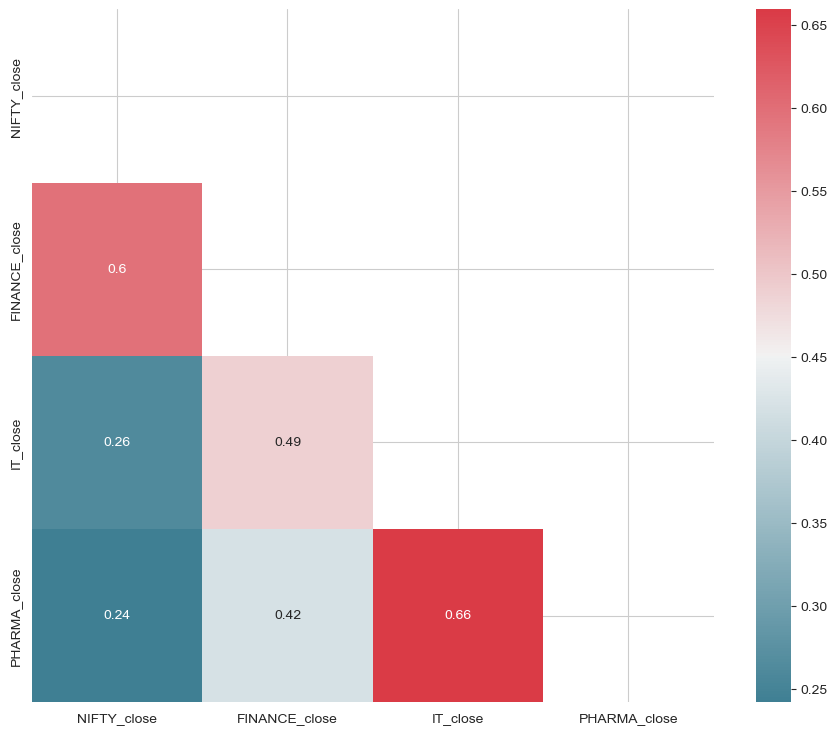

In [28]:
# Compute the correlation matrix for daily returns
corr = returns.dropna().corr()

# Generate a mask for the upper triangle of the correlation matrix
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure for plotting
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap for the heatmap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask applied and annotated values
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True)

# Show the plot
plt.show()

### Model Building

In [29]:
# Reset random seeds to ensure reproducibility if there's any randomness involved
reset_random_seeds()

df = FINANCE
df.head()

,Open,High,Low,Close
Date,,,,
01-01-2014,4758.750000,4761.799805,4732.649902,4737.600098
02-01-2014,4734.950195,4808.399902,4648.950195,4665.000000
03-01-2014,4638.200195,4674.600098,4621.700195,4664.100098
06-01-2014,4659.750000,4659.750000,4604.750000,4628.350098
07-01-2014,4640.549805,4666.600098,4570.049805,4619.250000


In [30]:
# Define hyperparameters for the model

# Number of previous timesteps to consider for prediction (can be changed)
window = 14  

# Number of timesteps in each input sequence (can be changed)
timesteps = 14  

# Batch size for training (can be changed)
batch_size = 64  # Batch size for training (can be changed)

# Number of epochs for training (can be changed)
num_epochs = 250

# Number of features in the input data
num_features = 5  

In [31]:
# Apply Larry Williams signal function to DataFrame
df = larry_williams_signal(df, window)

# Apply exponential moving average signal function to DataFrame
df = ema_signal(df, window)

# Apply moving average signal function to DataFrame
df = ma_signal(df, window)

# Apply stochastic signal function to DataFrame
df = stochastic_signal(df, window)

# Remove rows with NaN values (if any)
df.dropna(inplace=True)

#### Univariate Analysis

In [32]:
# Selecting relevent series
series_univariate = df['Close']
series_univariate = series_univariate.values.reshape(-1, 1)

print(series_univariate.shape)

(2454, 1)


In [33]:
# train_test_split function splits the data into two subsets: train_data and test_data.
train_data, test_data = split_data(series_univariate)

(1717, 1) (737, 1)


In [34]:
# Normalizes the train and test data using StandardScaler.
train_normalized, test_normalized, scalar = normalize_data(train_data, test_data)

(1717, 1) (737, 1)


In [35]:
# Function to train different types of recurrent neural network models.
LSTM_model= train_model(train_normalized,timesteps,batch_size,num_epochs, model_type='LSTM')
SimpleRNN_model = train_model(train_normalized,timesteps,batch_size,num_epochs, model_type='SimpleRNN')
GRU_model = train_model(train_normalized,timesteps,batch_size,num_epochs, model_type='GRU')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              

23/23 [==============================] - 0s 4ms/step
Model      MSE     RMSE  R-Squared  Aggregate Metrics
  GRU 0.001766 0.042023   0.901523          41.565925


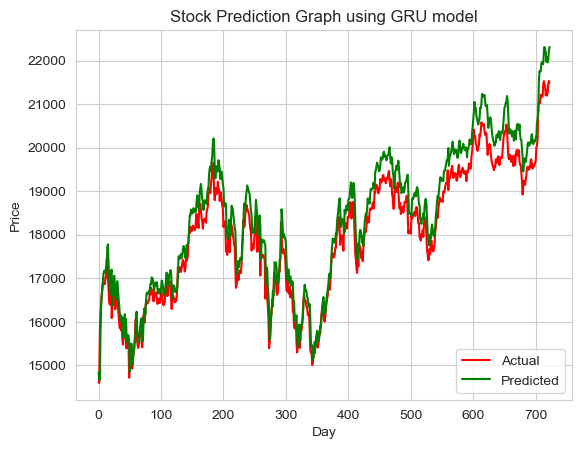

In [36]:
# Function to evaluates multiple recurrent neural network models and plots their predictions against the actual values
results_univatiate = evaluate_and_plot(LSTM_model, SimpleRNN_model, GRU_model, test_normalized, timesteps, num_features, scalar)

#### Continuous Data

In [37]:
# Selecting relevent series
series_continuous = df[['Close', 'EMA', 'SMA', 'Stochastic', 'Williams']]

print(series_continuous.shape)
print(series_continuous.head())

(2454, 5)
                  Close          EMA          SMA  Stochastic   Williams
Date                                                                    
20-01-2014  4631.500000  4650.521845  4639.914307   35.237062 -64.762938
21-01-2014  4684.500000  4655.052266  4636.121442   54.640327 -45.359673
22-01-2014  4696.649902  4660.598618  4638.382150   86.263932 -13.736068
23-01-2014  4714.049805  4667.725443  4641.949986   93.932079  -6.067921
24-01-2014  4639.549805  4663.968691  4642.749965   54.793670 -45.206330


In [38]:
# Get summary statistics for each column
summary_stats = series_continuous.describe()

# Print summary statistics
print(summary_stats)

              Close           EMA           SMA   Stochastic     Williams
count   2454.000000   2454.000000   2454.000000  2454.000000  2454.000000
mean   11974.653891  11930.684762  11930.282730    59.368712   -40.631288
std     4552.218159   4531.329173   4534.717837    30.636937    30.636937
min     4313.500000   4394.011307   4363.946429     1.048294   -98.951706
25%     7707.212525   7677.483797   7692.561593    33.305295   -66.694705
50%    11015.324710  10965.722937  10984.715997    64.447690   -35.552310
75%    16363.962160  16275.659764  16266.363474    87.929535   -12.070465
max    21534.099610  21253.485732  21350.199777    99.486542    -0.513458


In [39]:
# train_test_split function splits the data into two subsets: train_data and test_data.
train_data, test_data = split_data(series_continuous)

(1717, 5) (737, 5)


In [40]:
# Normalizes the train and test data using StandardScaler.
train_normalized, test_normalized, scalar = normalize_data(train_data, test_data)

(1717, 5) (737, 5)


In [41]:
# Function to train different types of recurrent neural network models.
LSTM_model= train_model(train_normalized,timesteps,batch_size,num_epochs, model_type='LSTM')
SimpleRNN_model = train_model(train_normalized,timesteps,batch_size,num_epochs, model_type='SimpleRNN')
GRU_model = train_model(train_normalized,timesteps,batch_size,num_epochs, model_type='GRU')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 64)            17920     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              

23/23 [==============================] - 0s 4ms/step
    Model      MSE     RMSE  R-Squared  Aggregate Metrics
SimpleRNN 0.001826 0.042727   0.898201          41.434286


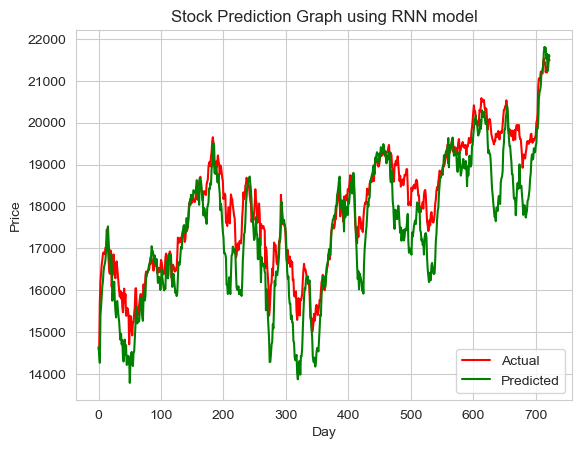

In [42]:
# Function to evaluates multiple recurrent neural network models and plots their predictions against the actual values
results_continuous = evaluate_and_plot(LSTM_model, SimpleRNN_model, GRU_model, test_normalized, timesteps, num_features, scalar)

#### Discrete Data

In [43]:
# Selecting relevent series
series_discrete = df[['Close', 'EMA_discrete', 'SMA_discrete', 'Stochastic_discrete', 'Williams_discrete']]

print(series_discrete.shape)
print(series_discrete.head())

(2454, 5)
                  Close  EMA_discrete  SMA_discrete  Stochastic_discrete  \
Date                                                                       
20-01-2014  4631.500000            -1            -1                    0   
21-01-2014  4684.500000             1             1                    1   
22-01-2014  4696.649902             1             1                    1   
23-01-2014  4714.049805             1             1                    1   
24-01-2014  4639.549805            -1            -1                   -1   

            Williams_discrete  
Date                           
20-01-2014                  0  
21-01-2014                  1  
22-01-2014                  1  
23-01-2014                  1  
24-01-2014                 -1  


In [44]:
# train_test_split function splits the data into two subsets: train_data and test_data.
train_data, test_data = split_data(series_discrete)

(1717, 5) (737, 5)


In [45]:
#Normalizes the train and test data using StandardScaler.
train_normalized, test_normalized, scalar = normalize_data(train_data, test_data)

(1717, 5) (737, 5)


In [46]:
#Function to train different types of recurrent neural network models.
LSTM_model= train_model(train_normalized,timesteps,batch_size,num_epochs, model_type='LSTM')
SimpleRNN_model = train_model(train_normalized,timesteps,batch_size,num_epochs, model_type='SimpleRNN')
GRU_model = train_model(train_normalized,timesteps,batch_size,num_epochs, model_type='GRU')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 14, 64)            17920     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              

23/23 [==============================] - 1s 8ms/step
Model      MSE     RMSE  R-Squared  Aggregate Metrics
  GRU 0.000639 0.025279   0.964365          46.840844


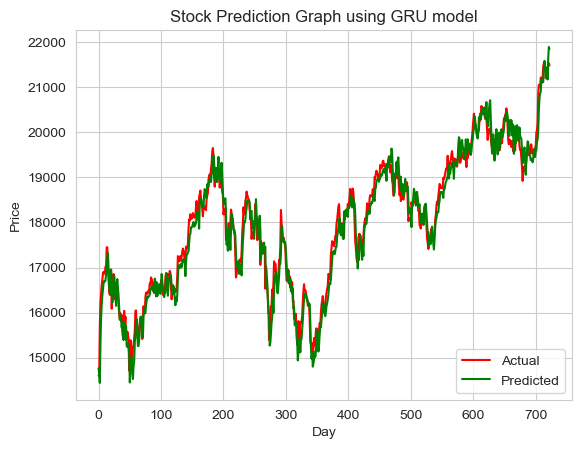

In [47]:
# Function to evaluates multiple recurrent neural network models and plots their predictions against the actual values
results_discrete = evaluate_and_plot(LSTM_model, SimpleRNN_model, GRU_model, test_normalized, timesteps, num_features, scalar)

### Model Results

In [48]:
# Visualizes the results of continuous and discrete data.
visualize_results(results_univatiate,results_continuous, results_discrete)


Results for Univariate Data:
+-----------+-----------------------+---------------------+--------------------+-------------------+
|   Model   |          MSE          |        RMSE         |     R-Squared      | Aggregate Metrics |
+-----------+-----------------------+---------------------+--------------------+-------------------+
|   LSTM    | 0.0018102021096825427 | 0.04254647000260471 | 0.8990568072589433 | 41.46758977824418 |
| SimpleRNN | 0.0034129257536826786 | 0.05842025122919858 | 0.8096833384945485 | 39.30901175542761 |
|    GRU    | 0.0017659683618323624 | 0.04202342634569869 | 0.9015234355492413 | 41.56592480231333 |
+-----------+-----------------------+---------------------+--------------------+-------------------+
Results for Continuous Data:
+-----------+-----------------------+---------------------+--------------------+--------------------+
|   Model   |          MSE          |        RMSE         |     R-Squared      | Aggregate Metrics  |
+-----------+-----------------